In [1]:
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy.fft import fft, fftfreq, fftshift

# load data

In [2]:
train_data = np.load('../data/raw/train_samples.win500.npy', allow_pickle=True)
test_data = np.load('../data/raw/two_stage_test.npy', allow_pickle=True)

In [3]:
train_data.shape, test_data.shape

((324552,), (15696,))

In [4]:
df_train = pd.DataFrame(list(train_data))
df_test = pd.DataFrame(list(test_data))

# save tiny datasets for tests

In [26]:
ind_list = []
ind_list.extend(df_train[(df_train['person'] == 'SC4062') & (df_train['label'] == 'Sleep stage 4')].index[:5].tolist())
ind_list.extend(df_train[(df_train['person'] == 'SC4062') & (df_train['label'] == 'Sleep stage W')].index[:5].tolist())
ind_list.extend(df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage 4')].index[:5].tolist())
ind_list.extend(df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage W')].index[:5].tolist())
ind_list.extend(df_train[(df_train['person'] == 'SC4141') & (df_train['label'] == 'Sleep stage 4')].index[:5].tolist())
ind_list.extend(df_train[(df_train['person'] == 'SC4321') & (df_train['label'] == 'Sleep stage W')].index[:5].tolist())

In [36]:
ind_list[0]

52872

In [27]:
len(ind_list)

30

In [29]:
train_data_tiny = train_data[ind_list]
test_data_tiny = test_data[:10]

In [30]:
df_train_tiny = pd.DataFrame(list(train_data_tiny))
df_test_tiny = pd.DataFrame(list(test_data_tiny))

In [31]:
df_train_tiny['target'] = None
df_train_tiny.loc[df_train_tiny['label'] == 'Sleep stage 4', 'target'] = 1
df_train_tiny.loc[df_train_tiny['label'] == 'Sleep stage W', 'target'] = 0

df_test_tiny['target'] = None
df_test_tiny.loc[df_test_tiny['label'] == 'Sleep stage 4', 'target'] = 1
df_test_tiny.loc[df_test_tiny['label'] == 'Sleep stage W', 'target'] = 0

In [33]:
assert df_train_tiny['target'].mean() > 0
assert df_train_tiny['person'].nunique() > 1

In [34]:
with open('../tests/data/train_tiny.npy', 'wb') as f_out:
    np.save(f_out, train_data_tiny, allow_pickle=True)

In [35]:
with open('../tests/data/test_tiny.npy', 'wb') as f_out:
    np.save(f_out, test_data_tiny, allow_pickle=True)

# check nans

In [6]:
df_train.isna().sum()

label     0
time      0
value     0
person    0
dtype: int64

In [7]:
check_nan_values = df_train['value'].apply(lambda x: np.isnan(x).sum())

In [8]:
check_nan_values.sum()

0

# train test mean target

In [12]:
ss4_train_count = df_train[df_train['label'] == 'Sleep stage 4'].shape[0]
ssw_train_count = df_train[df_train['label'] == 'Sleep stage W'].shape[0]
ss4_test_count = df_test[df_test['label'] == 'Sleep stage 4'].shape[0]
ssw_test_count = df_test[df_test['label'] == 'Sleep stage W'].shape[0]

In [15]:
ss4_train_count / (ss4_train_count + ssw_train_count), ss4_test_count / (ss4_test_count + ssw_test_count)

(0.014655568605423072, 0.5229357798165137)

# basic describe

In [18]:
df_train.head()

,label,time,value,person
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022


In [11]:
df_train.dtypes

label     object
time      object
value     object
person    object
dtype: object

In [18]:
df_train['time'] = df_train['time'].astype(int)

In [124]:
df_train['shape_value'] = df_train['value'].apply(lambda x: x.shape[0])

In [125]:
df_train[['shape_value']].describe()

,shape_value
count,324552.0
mean,500.0
std,0.0
min,500.0
25%,500.0
50%,500.0
75%,500.0
max,500.0


In [140]:
df_train['fpz_min'] = df_train['value'].apply(lambda x: x[:, 0].min())
df_train['fpz_max'] = df_train['value'].apply(lambda x: x[:, 0].max())
df_train['fpz_median'] = df_train['value'].apply(lambda x: np.median(x[:, 0]))
df_train['fpz_mean'] = df_train['value'].apply(lambda x: x[:, 0].mean())
df_train['fpz_std'] = df_train['value'].apply(lambda x: x[:, 0].std())
df_train['pz_min'] = df_train['value'].apply(lambda x: x[:, 1].min())
df_train['pz_max'] = df_train['value'].apply(lambda x: x[:, 1].max())
df_train['pz_median'] = df_train['value'].apply(lambda x: np.median(x[:, 1]))
df_train['pz_mean'] = df_train['value'].apply(lambda x: x[:, 1].mean())
df_train['pz_std'] = df_train['value'].apply(lambda x: x[:, 1].std())

In [141]:
df_train.head()

,label,time,value,person,label_int,label_test,shape_value,fpz_min,fpz_max,fpz_median,fpz_mean,fpz_std,pz_min,pz_max,pz_median,pz_mean,pz_std
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022,1,Sleep stage W,500,-83.945543,76.362637,8.647863,7.816580,29.445569,-16.111111,11.153846,1.367521,0.831966,4.483461
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022,1,Sleep stage W,500,-104.334799,63.268620,-6.971429,-8.699652,24.046130,-27.478632,32.521368,1.666667,1.415897,5.026229
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022,1,Sleep stage W,500,-32.598291,70.470330,2.100855,3.735736,16.321520,-14.401709,20.042735,1.837607,2.157436,6.180174
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022,1,Sleep stage W,500,-61.779243,47.649328,1.165568,2.097675,15.887129,-24.316239,14.572650,-4.230769,-4.344103,4.765584
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022,1,Sleep stage W,500,-82.168498,92.449573,-6.784371,-4.315775,34.115430,-44.829060,60.042735,-1.837607,-0.618462,20.248743


In [142]:
df_train.describe()

,time,label_int,shape_value,fpz_min,fpz_max,fpz_median,fpz_mean,fpz_std,pz_min,pz_max,pz_median,pz_mean,pz_std
count,324552.000000,324552.000000,324552.0,324552.000000,324552.000000,324552.000000,324552.000000,324552.000000,324552.000000,324552.000000,3.245520e+05,324552.000000,324552.000000
mean,40768.833284,1.799379,500.0,-65.332110,65.246133,-0.266951,0.001240,23.236162,-29.009482,30.195959,-4.003848e-02,0.035152,9.721187
std,24280.110441,1.471708,0.0,36.925244,37.844438,4.413526,3.504617,14.474080,21.038068,21.426952,1.944702e+00,1.501733,7.962285
min,0.000000,1.000000,500.0,-202.000000,-4.458364,-49.059829,-31.125172,0.768313,-201.000000,-0.284493,-7.581905e+01,-31.369968,0.730295
25%,19340.000000,1.000000,500.0,-85.798291,35.208059,-2.014408,-1.377374,12.257345,-35.605861,16.361416,-7.626374e-01,-0.617034,5.512111
50%,40445.000000,1.000000,500.0,-60.340171,57.401465,-0.114286,0.040596,20.047045,-23.139683,24.774603,-1.700029e-16,0.070814,7.866430
75%,62050.000000,3.000000,500.0,-35.794872,87.092796,1.523077,1.370231,30.591729,-15.760440,37.435653,7.338217e-01,0.747839,11.337918
max,85735.000000,8.000000,500.0,0.045910,200.000000,42.616361,26.350444,141.321277,-0.927961,202.000000,7.007778e+01,35.201695,137.331279


In [6]:
df_test['time'].astype(int).max()

30775

In [91]:
df_test['fpz_min'] = df_test['value'].apply(lambda x: x[:, 0].min())
df_test['fpz_max'] = df_test['value'].apply(lambda x: x[:, 0].max())
df_test['fpz_median'] = df_test['value'].apply(lambda x: np.median(x[:, 0]))
df_test['fpz_mean'] = df_test['value'].apply(lambda x: x[:, 0].mean())
df_test['fpz_std'] = df_test['value'].apply(lambda x: x[:, 0].std())
df_test['pz_min'] = df_test['value'].apply(lambda x: x[:, 1].min())
df_test['pz_max'] = df_test['value'].apply(lambda x: x[:, 1].max())
df_test['pz_median'] = df_test['value'].apply(lambda x: np.median(x[:, 1]))
df_test['pz_mean'] = df_test['value'].apply(lambda x: x[:, 1].mean())
df_test['pz_std'] = df_test['value'].apply(lambda x: x[:, 1].std())

In [92]:
df_test.describe()

,fpz_min,fpz_max,fpz_median,fpz_mean,fpz_std,pz_min,pz_max,pz_median,pz_mean,pz_std
count,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000
mean,-1.438412,1.424796,-0.056595,-0.048683,0.591550,-1.321870,1.125065,-0.069557,-0.068108,0.505906
std,1.431712,1.598690,0.797424,0.765885,0.446033,2.033186,2.265138,1.171491,1.147300,0.619878
min,-44.903326,-18.338566,-18.338566,-18.338566,0.000000,-62.028286,-26.143431,-26.143431,-26.143431,0.000000
25%,-1.939619,0.666192,-0.203324,-0.203946,0.277461,-1.686427,0.414798,-0.171046,-0.179189,0.171569
50%,-1.287824,1.187902,-0.028052,-0.034455,0.535681,-1.038094,0.899095,-0.038255,-0.046378,0.386054
75%,-0.690801,1.883516,0.133528,0.131572,0.775624,-0.561608,1.445882,0.086725,0.071181,0.651347
max,25.654868,43.779155,32.008502,30.430708,9.760743,36.596479,63.451535,36.596479,36.596479,14.042590


## value counts

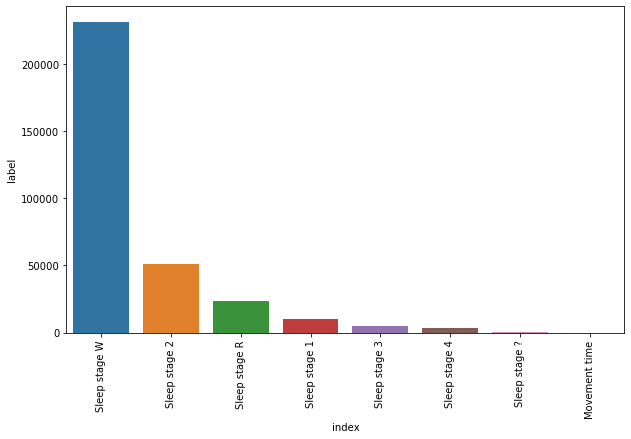

In [54]:
fig = plt.figure(figsize=(10, 6))

sns.barplot(
    x='index',
    y='label',
    data=df_train['label'].value_counts().reset_index()
)
plt.xticks(rotation='90')
plt.show()

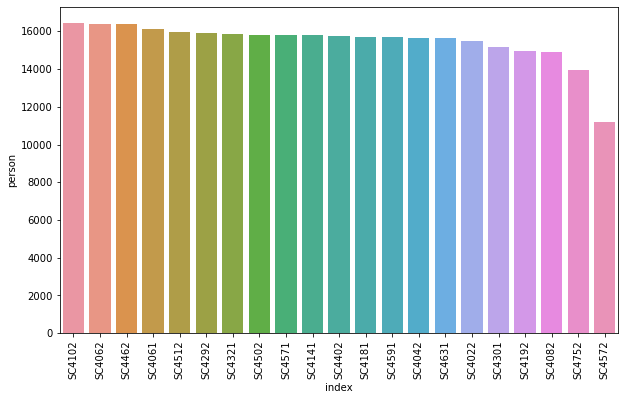

In [55]:
fig = plt.figure(figsize=(10, 6))

sns.barplot(
    x='index',
    y='person',
    data=df_train['person'].value_counts().reset_index()
)
plt.xticks(rotation='90')
plt.show()

## labels

In [12]:
df_train['label'].unique()

array(['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage R', 'Movement time', 'Sleep stage ?'],
      dtype=object)

In [13]:
df_train['label_int'] = df_train['label'].map({x: i + 1 for i, x in enumerate(df_train['label'].unique())})

In [14]:
df_train.head()

,label,time,value,person,label_int
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022,1
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022,1
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022,1
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022,1
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022,1


In [15]:
df_train[['label', 'label_int']].drop_duplicates()

,label,label_int
0,Sleep stage W,1
4536,Sleep stage 1,2
4728,Sleep stage 2,3
4836,Sleep stage 3,4
4908,Sleep stage 4,5
5772,Sleep stage R,6
138396,Movement time,7
263544,Sleep stage ?,8


In [16]:
df_train['label_test'] = df_train['label_int'].map(
    {1: 'Sleep stage W', 2: 'other', 3: 'other', 4: 'other', 5: 'Sleep stage 4', 6: 'other', 7: 'other', 8: 'other'}
)

### sleep stages timeline

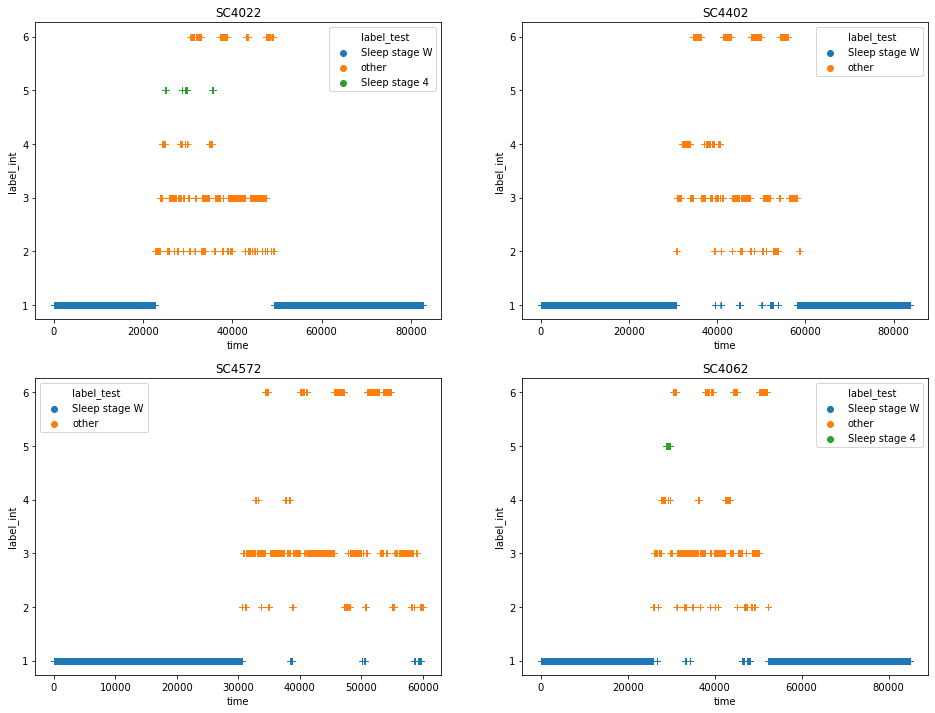

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, person in enumerate(['SC4022', 'SC4572', 'SC4402', 'SC4062']):
    sns.scatterplot(
        x='time',
        y='label_int',
        hue='label_test',
        data=df_train[df_train['person'] == person],
        marker="+",
        ax=axes[i % 2][i // 2]
    )
    axes[i % 2][i // 2].set_title(person)

In [146]:
df_train_gr = df_train.groupby('label').mean()

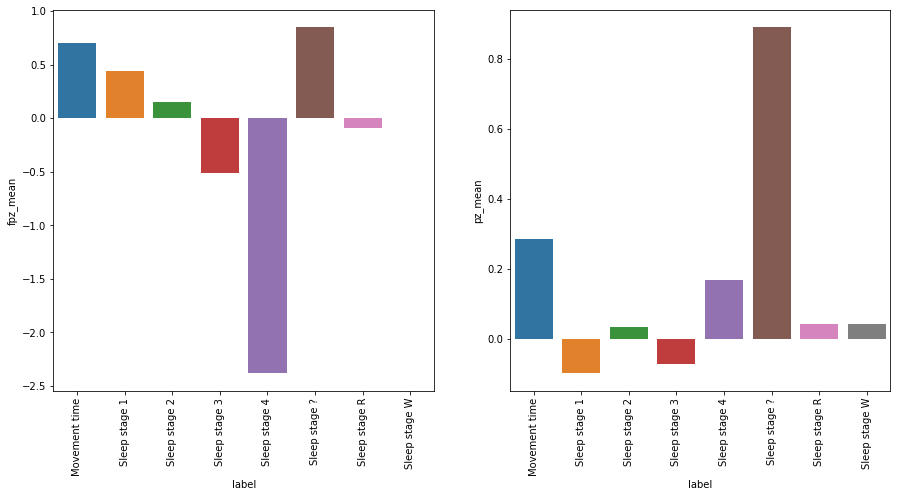

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.barplot(x=df_train_gr.index , y='fpz_mean', data=df_train_gr, ax=ax[0])
ax[0].set_xticklabels(df_train_gr.index, rotation=90)
sns.barplot(x=df_train_gr.index , y='pz_mean', data=df_train_gr, ax=ax[1])
plt.xticks(rotation=90)
plt.show()

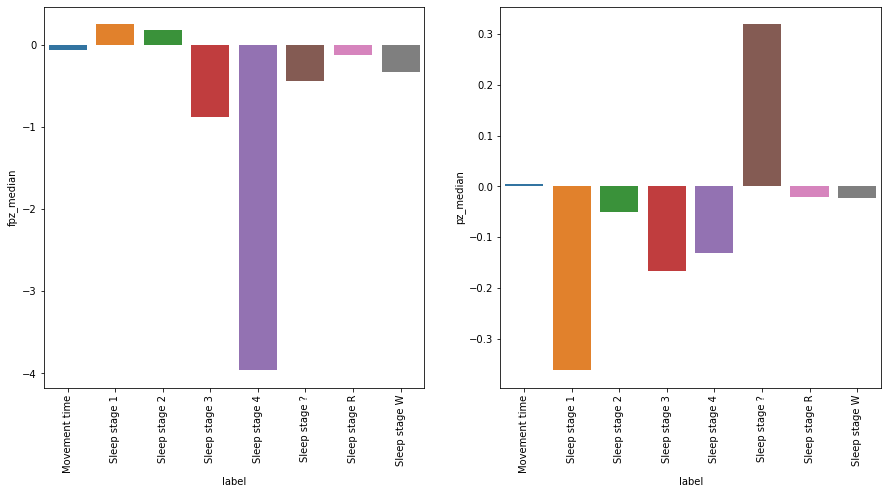

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.barplot(x=df_train_gr.index , y='fpz_median', data=df_train_gr, ax=ax[0])
ax[0].set_xticklabels(df_train_gr.index, rotation=90)
sns.barplot(x=df_train_gr.index , y='pz_median', data=df_train_gr, ax=ax[1])
plt.xticks(rotation=90)
plt.show()

# Fpz Pz dist

In [27]:
fpz_list = []
pz_list = []
for row in df_train[df_train['person'] == 'SC4022'].iterrows():
    fpz_list.append(row[1]['value'][:, 0])
    pz_list.append(row[1]['value'][:, 1])
    
fpz_array = np.array(fpz_list).flatten()
pz_array = np.array(pz_list).flatten()

In [32]:
fpz_list = []
pz_list = []
for row in df_test.iterrows():
    fpz_list.append(row[1]['value'][:, 0])
    pz_list.append(row[1]['value'][:, 1])

fpz_array_test = np.array(fpz_list).flatten()
pz_array_test = np.array(pz_list).flatten()

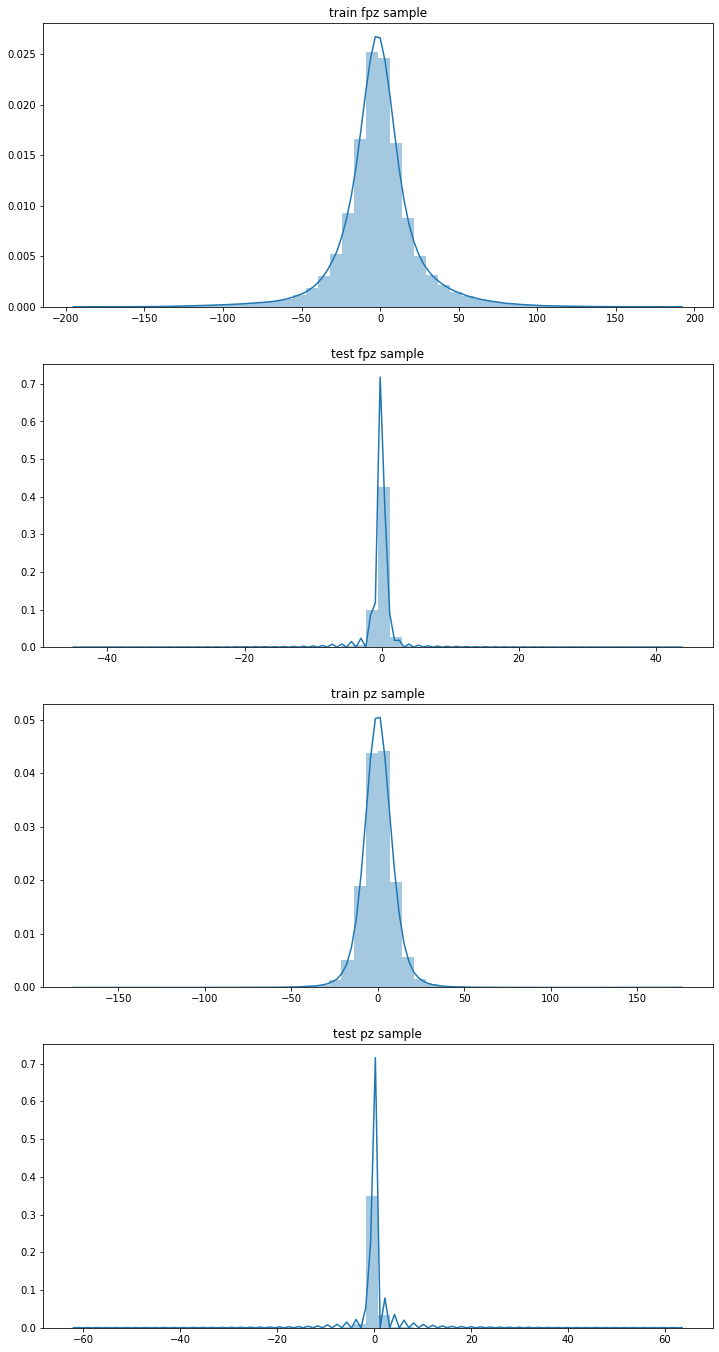

In [34]:
fig, axes = plt.subplots(4, figsize=(12, 24))
sns.distplot(fpz_array, ax=axes[0])
axes[0].set_title('train fpz sample')
sns.distplot(fpz_array_test, ax=axes[1])
axes[1].set_title('test fpz sample')
sns.distplot(pz_array, ax=axes[2])
axes[2].set_title('train pz sample')
sns.distplot(pz_array_test, ax=axes[3])
axes[3].set_title('test pz sample')
plt.show()

In [30]:
normaltest(fpz_array)

NormaltestResult(statistic=880663.9326965022, pvalue=0.0)

In [31]:
normaltest(pz_array)

NormaltestResult(statistic=2102759.1270483783, pvalue=0.0)

In [35]:
normaltest(fpz_array_test)

NormaltestResult(statistic=7249587.148858573, pvalue=0.0)

In [36]:
normaltest(pz_array_test)

NormaltestResult(statistic=7836627.338628698, pvalue=0.0)

# fft

In [53]:
fpz_w = df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage W')].iloc[5]['value'][:, 0]
fpz_4 = df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage 4')].iloc[5]['value'][:, 0]
pz_w = df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage W')].iloc[5]['value'][:, 1]
pz_4 = df_train[(df_train['person'] == 'SC4022') & (df_train['label'] == 'Sleep stage 4')].iloc[5]['value'][:, 1]
fpz_mt = df_train[df_train['label'] == 'Movement time'].iloc[0]['value'][:, 0]
pz_mt = df_train[df_train['label'] == 'Movement time'].iloc[0]['value'][:, 1]

fft_list = [
    ('fpz_w', fpz_w),
    ('pz_w', pz_w),
    ('fpz_4', fpz_4),
    ('pz_4', pz_4),
    ('fpz_mt', fpz_mt),
    ('pz_mt', pz_mt)
]

In [54]:
def min_max_scale(yf_):
    yf_min = yf_.min()
    yf_max = yf_.max()
    return (yf_ - yf_min) / (yf_max - yf_min)

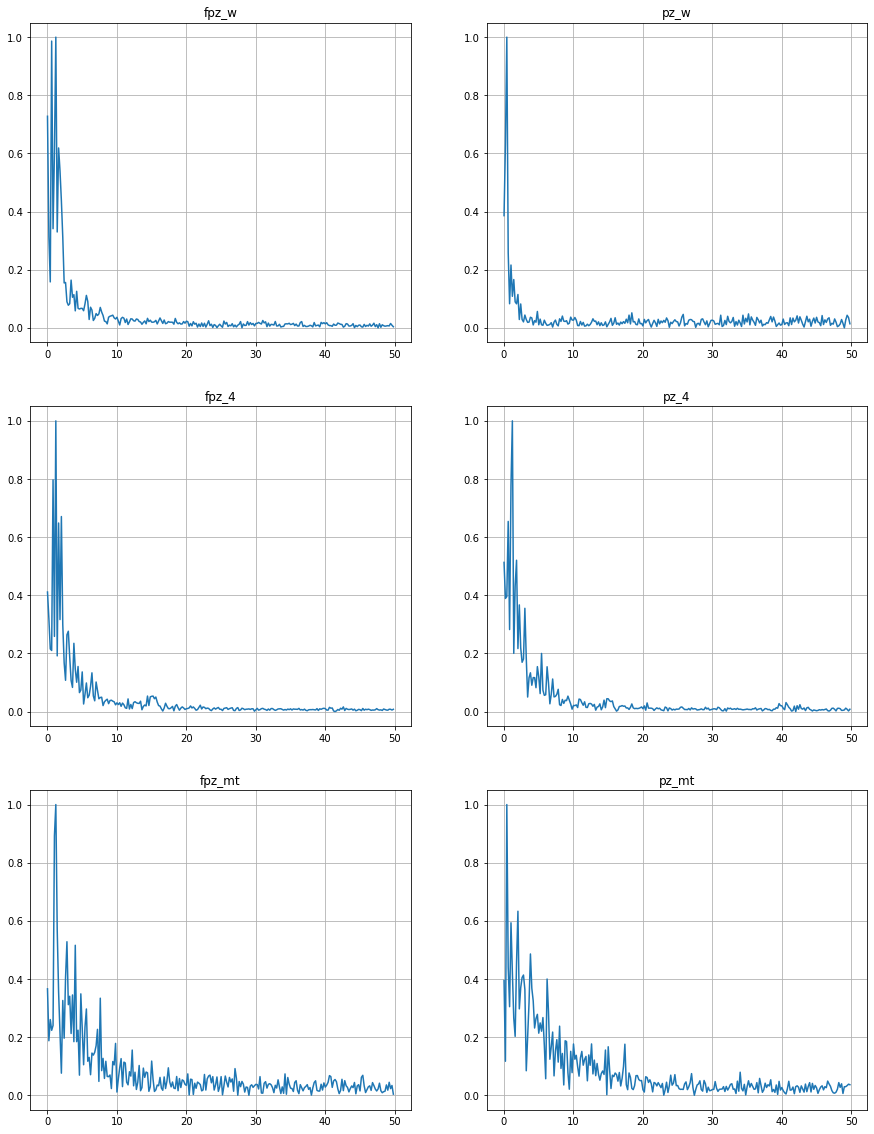

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
for i, (name, val) in enumerate(fft_list):
    N = val.shape[0]
    T = 5.0 / N

    yf = fft(val)
    xf = fftfreq(N, T)[:N//2]
    yf_ = 2.0/N * np.abs(yf[0:N//2])

    axes[i // 2][i % 2].plot(xf, min_max_scale(yf_))
    axes[i // 2][i % 2].set_title(name)
    axes[i // 2][i % 2].grid()
plt.show()

### choped

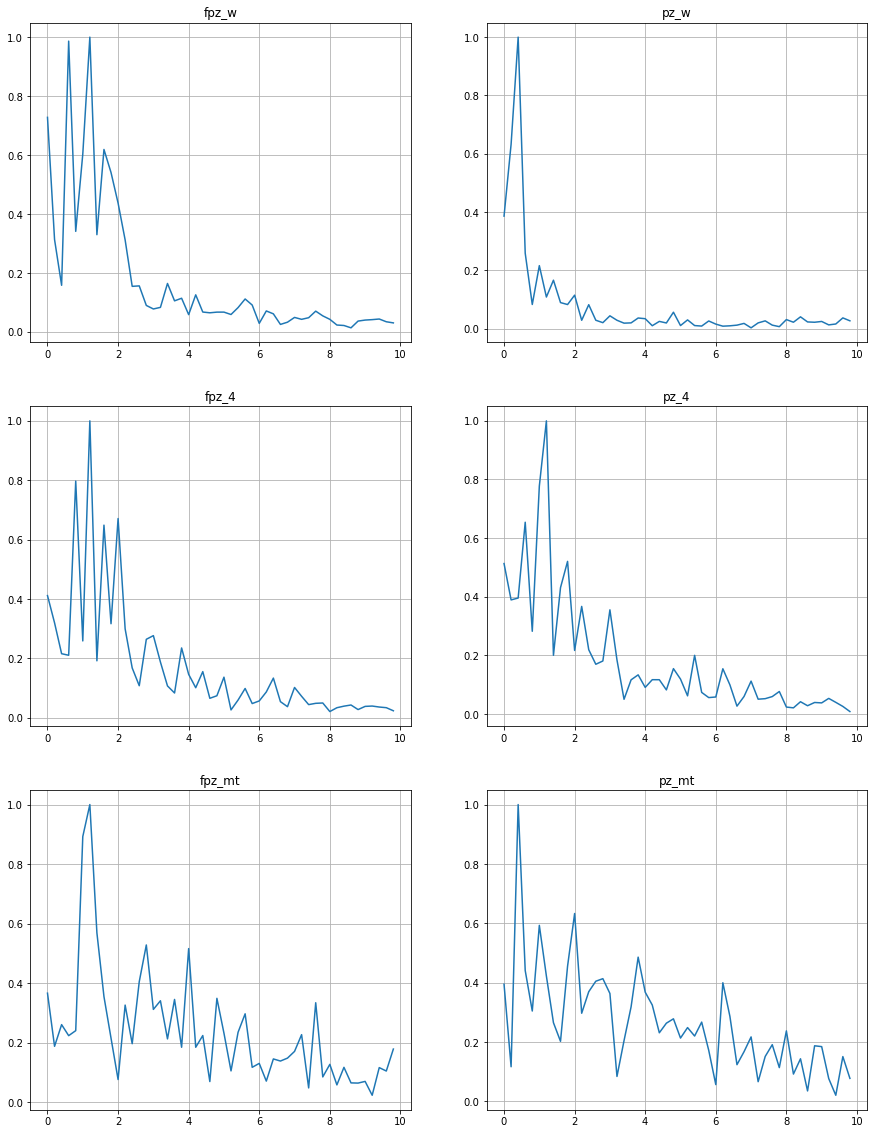

In [59]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
for i, (name, val) in enumerate(fft_list):
    N = val.shape[0]
    T = 5.0 / N

    yf = fft(val)
    xf = fftfreq(N, T)[:N//2]
    yf_ = 2.0/N * np.abs(yf[0:N//2])

    axes[i // 2][i % 2].plot(xf[:50], min_max_scale(yf_)[:50])
    axes[i // 2][i % 2].set_title(name)
    axes[i // 2][i % 2].grid()
plt.show()